# The Search for a Good ECC
We will be a using a random linear code, aka a full-rank random 0-1 matrix. However, not all randomly generated matrices are equal. Here we very elegantly brute-force search through many random matrices, and for each we assess their quality. Quality in this case is mostly captured by the code's minimum distance (the minimum number of bits that are different between any two codeword). We also calculate an approximation of how likely it is that a codeword would decode to in the incorrect message. The latter measurement is dependent on the per-bit corruption rate.

## A note about memoization
Assessing the quality of a random linear code is computationally expensive. Even with a multi-threaded c program it takes upwards of 2 seconds per matrix. To avoid having to recalculate we store results in a csv file called `assessment_results.csv`. When the function `assess_matrix` is called, it first checks to see if the results have already been stored in `assessment_results.csv`. Only if it cannot find the results will it run the `assess_matrix` executable. The formatting of `assessment_results.csv` must remain the same so that we can continue to look up memoized results and add new results. Please don't edit this file manually or change the csv formatting in the following code!

In [1]:
import scipy as sc
from scipy.stats import binom
from scipy.sparse import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from subprocess import check_output, call
from io import StringIO
import sys
import uuid
import os

def incorrect_decoding_rate(corruption_rate, weight):
    '''Probability that the all-zeroes codeword is decoded to some other codeword with weight weight.
    The all-zeroes codeword will be decoded incorrectly to this other codeword if it accumulates at least
    weight/2 errors in the specific bit locations where this other codeword has value 1. Errors that occur
    at other bit locations can be ignored since they do not make the all-zeroes codeword look more similar
    to the other codeword.
    @param corruption_rate: per-bit corruption rate. This is often 0.02 or 0.03 in our case.
    @param weight: weight
    @return: The rate (chance) of incorrect decoding to a codeword of weight'''
    error_prob = 0
    for i in range(int(np.ceil(weight/2.0)), weight):
        error_prob += binom.pmf(i, weight, corruption_rate)
    return error_prob

def cumulative_incorrect_decoding_rate(corruption_rate, weight_buckets):
    '''Probability that the all-zeroes codeword is incorrectly decoded.
    The chance of incorrect decoding would be high for low-weight codewords, but we expect there to be
    zero such codewords, so weight_buckets[weight] will be zero and eliminate many of those terms.
    @param corruption_rate: per-bit error rate
    @param weights: array of weight bucket counts. The indices of this array correspond to weight values while the array values are the count of how many codewords have that weight.
    @return: The rate (chance) of incorrectly decoding to any other codeword.'''
    return [weight_buckets[weight] * incorrect_decoding_rate(corruption_rate, weight) for weight in range(len(weight_buckets))]

# ATTENTION: If you change this function it will make everything in assessment_results.csv invalid.
# For our memoization strategy to work, generating the matrices must be consistent.
def create_random_matrix(n, k, seed):
    '''Uses scipy.sparse.random to create a random 0/1 matrix with density 0.5. This is concatenated to an identity matrix
    to create a k-by-n matrix.
    @param n: Length of a codeword
    @param k: Length of a message
    @param seed: An integer that is passed to scipy.sparse.random
    @return: A numpy ndarray'''
    return np.concatenate((np.identity(k), np.ceil(random(k, n-k, density=0.5, random_state=seed).toarray())), axis=1)

column_names = ["n", "k", "seed", "distance", "corruption_rate", "incorrect_decoding_rate", "weights"]
def assess_matrix(n, k, seed, corruption_rate, memoized_results):
    '''
    Finds the distance and weights of the code represented by n, k, and seed. Calculates an approximate chance
    of incorrect decoding, based on a particular corruption rate.
    @param n: Length of a codeword
    @param k: Length of a message
    @param seed: An integer that will determine how the random matrix is built
    @param corruption_rate: Chance that a single bit is corrupted
    @param memoized_results: Pre-calculated results
    @return: A pandas Series'''
    # First, see if the results are already present in our memoized_results
    matching_matrices = memoized_results[
        (memoized_results["n"]==n) &
        (memoized_results["k"]==k) &
        (memoized_results["seed"]==seed)]
    if (matching_matrices.empty):
        # Okay, have to actually build the matrix and run a new assessment
        matrix = create_random_matrix(n, k, seed)

        # Assess the matrix with the C code
        filename = str(uuid.uuid4()) + ".temp"
        np.savetxt(filename, matrix, fmt="%d", delimiter="")
        try:
            # Make a correct executable
            if(call(["make", "clean"]) != 0):
                print("Couldn't make clean. Cannot continue.", file=sys.stderr)
                exit(1)
            if(call(["make", "THREAD_POW=6", "K="+str(k), "N="+str(n)]) != 0):
                print("Couldn't make executable. Cannot continue.", file=sys.stderr)
                exit(1)
            result = check_output(["./assess_matrix", filename])
        finally:
            os.remove(filename)

        # Calculate the chance of incorrect decoding and minimum distance
        weights = pd.read_csv(StringIO(result.decode('utf-8')))["Count"].tolist()
        err = sum(cumulative_incorrect_decoding_rate(corruption_rate, weights))
        distance = np.nonzero(weights)[0][1]
        return pd.Series([n, k, seed, distance, corruption_rate, err, str(weights)], column_names)
    elif (matching_matrices[matching_matrices["corruption_rate"]==corruption_rate].empty):
        # This matrix has been assessed, but not for this corruption rate.
        # We don't need to re-run the C code, just reuse the weights array.
        row = matching_matrices.iloc[0]
        distance = int(row["distance"])
        weights = np.fromstring(row["weights"][1:-1], sep=",")
        err = sum(cumulative_incorrect_decoding_rate(corruption_rate, weights))
        return pd.Series([n, k, seed, distance, corruption_rate, err, weights], column_names)
    else:
        return matching_matrices[matching_matrices["corruption_rate"]==corruption_rate].iloc[0]
    

def assess_matrices(n, k, seeds, corruption_rates):
    '''
    Finds the distance and weights of each code represented by n, k, and seed. Calculates an approximate chance
    of incorrect decoding, based on each particular corruption rate.
    @param n: Length of a codeword
    @param k: Length of a message
    @param seeds: A list of integers that will determine how the random matrix is built
    @param corruption_rate: A list of floats
    @return: A pandas DataFrame'''
    memoized_results = pd.read_csv("assessment_results.csv")
    for seed in seeds:
        print("Assessing seed: " + str(seed), end="\r")
        for corruption_rate in corruption_rates:
            row = assess_matrix(n, k, seed, corruption_rate, memoized_results)
            memoized_results = memoized_results.append(row, ignore_index=True)
        memoized_results = memoized_results.drop_duplicates(subset=["n", "k", "seed", "corruption_rate"])
    memoized_results.to_csv("assessment_results.csv", index=False)
    return memoized_results[
        (memoized_results["n"]==n) &
        (memoized_results["k"]==k) &
        (memoized_results["seed"].isin(seeds)) &
        (memoized_results["corruption_rate"].isin(corruption_rates))]

# Plot of the tradeoff between bits (k) and corruption rate

In [2]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.8)

In [17]:
corruption_rates = np.linspace(start=0.01, stop=0.1, num=10)
seeds = range(0,50)
n = 96

data_by_k = {}

for k in [16, 24, 32, 40]:
    # Collect Results
    print(k)
    results = assess_matrices(n, k, seeds, corruption_rates)
    trend = results.groupby(["corruption_rate"])["incorrect_decoding_rate"].mean()
    data_by_k[k] = {"results": results,
                    "trend": trend}

16
24sessing seed: 49
32sessing seed: 49
40sessing seed: 49


16
24
32
40


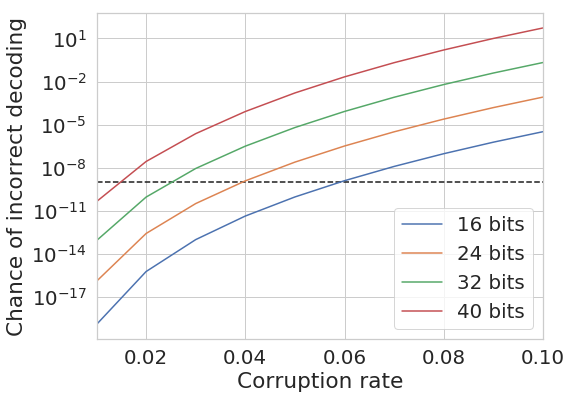

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

for k in [16, 24, 32, 40]:
    # Collect Results
    print(k)
    results = data_by_k[k]["results"]
    trend = data_by_k[k]["trend"]    
    ax.plot(trend, label="{0} bits".format(k))
    
ax.set_yscale("log")
ax.hlines(10**(-9), corruption_rates[0], corruption_rates[-1], linestyle="dashed")
ax.set_ylabel("Chance of incorrect decoding")
ax.set_xlabel("Corruption rate")
ax.set_xticks(corruption_rates, ["{0}%".format(int(x*100)) for x in corruption_rates])
ax.legend()
ax.set_xlim([corruption_rates[0], corruption_rates[-1]])
#plt.savefig('decoding_rates.png', dpi=600,
#            bbox_inches='tight', transparent=True)
plt.show()
fig.tight_layout()
fig.savefig("decoding_rates.svg")
fig.savefig("decoding_rates.png", dpi=300)


# Retrieve the chance of incorrect decoding at a specific corruption rate

In [21]:
corruption_rate = 0.0170
n = 96
k = 32
seeds = range(0, 50)
results = assess_matrices(n, k, seeds, [corruption_rate])

In [22]:
corr_1 = results.groupby(["corruption_rate"])["incorrect_decoding_rate"].mean()

In [23]:
corr_1

corruption_rate
0.017    1.602797e-11
Name: incorrect_decoding_rate, dtype: float64

In [24]:
corruption_rate = 0.03
n = 96
k = 32
seeds = range(0, 50)
results = assess_matrices(n, k, seeds, [corruption_rate])

In [25]:
results.groupby(["corruption_rate"])["incorrect_decoding_rate"].mean()

corruption_rate
0.03    8.777093e-09
Name: incorrect_decoding_rate, dtype: float64

## Add to plot

In [32]:
err_rate = corr_1.index[0]
incorrect_decoding_rate = list(corr_1)[0]

In [40]:
sns.set(style="white", font_scale=1.9)

16
24
32
40


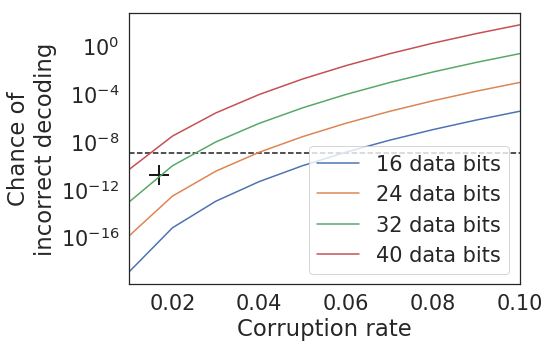

In [51]:
fig, ax = plt.subplots(figsize=(7, 5))

for k in [16, 24, 32, 40]:
    print(k)
    trend = data_by_k[k]["trend"]    
    ax.plot(trend, label="{0} data bits".format(k))
    
ax.scatter(err_rate, incorrect_decoding_rate, c="k", marker="+", s=400, linewidth=2)
ax.set_yscale("log")
ax.hlines(10**(-9), corruption_rates[0], corruption_rates[-1], linestyle="dashed")
ax.set_ylabel("Chance of\nincorrect decoding")
ax.set_xlabel("Corruption rate")
ax.set_xticks(corruption_rates, ["{0}%".format(int(x*100)) for x in corruption_rates])
ax.legend()
ax.set_xlim([corruption_rates[0], corruption_rates[-1]])
#plt.savefig('decoding_rates.png', dpi=600,
#            bbox_inches='tight', transparent=True)
plt.show()
fig.tight_layout()
fig.savefig("decoding_rates.svg")
fig.savefig("decoding_rates.png", dpi=300)


# Okay let's look at n=96 and k=32 specifically
__Note__: Since collecting results takes a number of seconds, up to a minute or more for 4000+ matrices (even when memoized), the data collection is separated into the following cell. It can be run once, and then the results will be consumed by the following plot-generating cells. Data is saved into variable `results`.

In [3]:
# Collect Results
seeds = range(0, 4000)
corruption_rates = np.linspace(start=0.02, stop=0.03, num=3)
results = assess_matrices(96, 32, seeds, corruption_rates)

In [4]:
results.describe()

,n,k,seed,distance,corruption_rate,incorrect_decoding_rate
count,12000.0,12000.0,12000.000000,12000.000000,12000.000000,1.200000e+04
mean,96.0,32.0,1999.500000,18.159250,0.025000,3.447870e-09
std,0.0,0.0,1154.748618,0.888794,0.004083,4.290068e-09
min,96.0,32.0,0.000000,14.000000,0.020000,5.564435e-11
25%,96.0,32.0,999.750000,18.000000,0.020000,1.019055e-10
50%,96.0,32.0,1999.500000,18.000000,0.025000,1.038535e-09
75%,96.0,32.0,2999.250000,19.000000,0.030000,8.222596e-09
max,96.0,32.0,3999.000000,20.000000,0.030000,7.149550e-08


## What sort of distance can these random codes achieve?
This assessment is independent of corruption rate. It simple generates a bunch of random matrices and calculates the distance for each. Higher is better!

__Note__: The variable `results` must already be populated (see section header)

The best matrices found have distance 20
We found 207 such matrices
They are generated with seeds: [66, 66, 66, 80, 80, 80, 274, 274, 274, 318, 318, 318, 404, 404, 404, 464, 464, 464, 475, 475, 475, 480, 480, 480, 572, 572, 572, 602, 602, 602, 709, 709, 709, 855, 855, 855, 864, 864, 864, 882, 882, 882, 922, 922, 922, 1039, 1056, 1159, 1180, 1361, 1402, 1531, 1533, 1547, 1582, 1680, 1765, 1794, 1820, 1832, 1964, 1965, 2063, 2068, 2130, 2149, 2198, 2236, 2346, 2393, 2451, 2576, 2577, 2641, 2779, 2832, 2898, 2904, 2969, 3007, 3029, 3136, 3160, 3231, 3238, 3265, 3317, 3342, 3347, 3418, 3440, 3618, 3629, 3636, 3666, 3702, 3703, 3789, 3982, 1039, 1039, 1056, 1056, 1159, 1159, 1180, 1180, 1361, 1361, 1402, 1402, 1531, 1531, 1533, 1533, 1547, 1547, 1582, 1582, 1680, 1680, 1765, 1765, 1794, 1794, 1820, 1820, 1832, 1832, 1964, 1964, 1965, 1965, 2063, 2063, 2068, 2068, 2130, 2130, 2149, 2149, 2198, 2198, 2236, 2236, 2346, 2346, 2393, 2393, 2451, 2451, 2576, 2576, 2577, 2577, 2641, 2641, 2779, 277

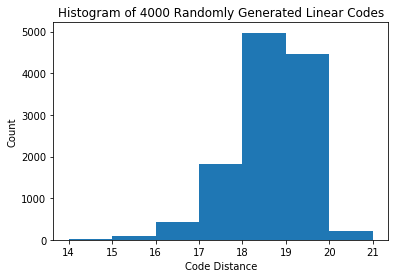

In [5]:
# Collect results
distances = results["distance"].tolist()

# Report results
print("The best matrices found have distance " + str(max(distances)))
best_seeds = results[results["distance"]==max(distances)]["seed"].tolist()
print("We found " + str(len(best_seeds)) + " such matrices")
print("They are generated with seeds: " + str(best_seeds))

# Display histogram
buckets = np.linspace(start=min(distances), stop=max(distances)+1, num=max(distances)-min(distances)+2)
plt.hist(distances, buckets)
plt.title("Histogram of " + str(len(seeds)) + " Randomly Generated Linear Codes")
plt.xlabel("Code Distance")
plt.ylabel("Count")
plt.show()

## And what does the incorrect decoding rate look like?
This assessment *does* depend on corruption rate. It will generate a bunch of matrices, and for each matrix it will calculate the chance of incorrect decoding for a variety of corruption rates. This gives us an idea of how well the code will perform, as well as how sensitive these codes are to changing corruption rates.

Smaller is better for incorrect decoding rate. We'd like to get below 10**(-9), or 1 incorrect decoding in a billion.

__Note__: The variable `results` must already be populated (see section header)

At a corruption rate of 0.02 the best matrix found have incorrect decoding rate of [5.56443520731005e-11, 5.651186578204756e-11, 5.662277906141261e-11, 5.676241364706005e-11, 5.694671081730175e-11]
It is generated with seeds: [3278, 3409, 1794, 3310, 3084]
And have distance: [19, 19, 20, 19, 19]
At a corruption rate of 0.025 the best matrix found have incorrect decoding rate of [7.87817038337707e-10, 7.885405821317105e-10, 7.927030829684589e-10, 7.932870471597178e-10, 7.99557649598792e-10]
It is generated with seeds: [3278, 3409, 1794, 3310, 1759]
And have distance: [19, 19, 20, 19, 19]
At a corruption rate of 0.03 the best matrix found have incorrect decoding rate of [7.323004644677005e-09, 7.3639084336756125e-09, 7.368765556022182e-09, 7.369796882575399e-09, 7.4135484903707535e-09]
It is generated with seeds: [3409, 3278, 1794, 3310, 1759]
And have distance: [19, 19, 20, 19, 19]


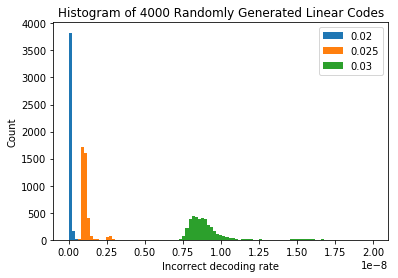

In [6]:
for corruption_rate in corruption_rates:
    # Report Results
    best_seeds = results[results["corruption_rate"]==corruption_rate].sort_values(
        by=["incorrect_decoding_rate"]).head(5)
    print("At a corruption rate of " + str(corruption_rate) + " the best matrix found have incorrect decoding rate of " + str(best_seeds["incorrect_decoding_rate"].tolist()))
    print("It is generated with seeds: " + str(best_seeds["seed"].tolist()))
    print("And have distance: " + str(best_seeds["distance"].tolist()))
    # Display histogram
    incorrect_decoding_rates = results[results["corruption_rate"]==corruption_rate]["incorrect_decoding_rate"].tolist()
    plt.hist(incorrect_decoding_rates, np.linspace(start=0, stop=2*10**(-8), num=100), label=str(corruption_rate))
plt.title("Histogram of " + str(len(seeds)) + " Randomly Generated Linear Codes")
plt.xlabel("Incorrect decoding rate")
plt.ylabel("Count")
plt.legend()
plt.show()

## And how does a code's distance correlate with the chance of incorrect decoding?
In the above histogram you can see that there are smaller secondary bumps. I suspected that these bumps were the code's that had lower (worse) distances. To further assess this we can look at a 2d histogram of distance and incorrect decoding rate. The brighter the color, the more matrices that have that distance and incorrect decoding rate. You can see that lower (worse) distance gives higher (worse) incorrect decoding rates. Furthermore, the lower distances also have a larger spread of incorrect decoding rates.

__Note__: The variable `results` must already be populated (see section header)

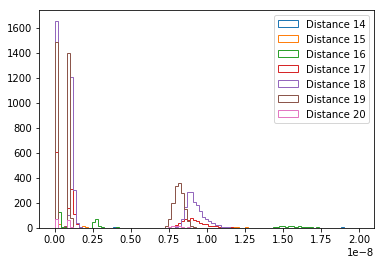

In [7]:
distances = results["distance"].tolist()
for distance in range(14,21):
    incorrect_decoding_rates = results[results["distance"]==distance]["incorrect_decoding_rate"].tolist()
    rates_buckets = np.linspace(start=0, stop=2*10**(-8), num=100)
    #distance_buckets = np.linspace(start=14, stop=21, num=8)
    #plt.hist2d(incorrect_decoding_rates, distances, [rates_buckets, distance_buckets])
    plt.hist(incorrect_decoding_rates, rates_buckets, histtype=u'step', label="Distance " + str(distance))
plt.legend()
plt.show()

## A look at the Gilbert-Varshamov Bound

The Gilbert-Varshamov Bound is a lower bound, meaning that it describes the best possible code out there. That is, it says "There is a code that does at least this well":

\begin{align*}
    q^k \ge \frac{q^n}{\sum_{j=0}^{d-1}\binom{n}{j}(q-1)^j}
\end{align*}

Which since we have `q=2`, `k=32`, and `n=96`, simplifies to:

\begin{align*}
    \sum_{j=0}^{d-1}\binom{96}{j} \ge 2^{64}
\end{align*}

This states that the best possible distance `d` will be such at the the expression on the left is at least 2<sup>64</sup>.

From [these notes](https://www.cs.cmu.edu/~venkatg/teaching/codingtheory/notes/notes2.pdf) we also get:

\begin{align*}
    k \ge n - \left \lfloor \log\sum_{j=0}^{d-2}\binom{n-1}{j} \right \rfloor - 1
\end{align*}

Since we are using q=2, a prime power, and are looking at a linear code.

In [8]:
import scipy.special
import math
total = 0
j = 0
while total < 2**65:
    total += scipy.special.comb(96, j)
    j += 1
print("When k=32 and n=96, d>=" + str(j))
        
# Alternately 
d = 20
n = 96
total = 0
for j in range(0, d-1):
    total += scipy.special.comb(n-1, j)
k = n - math.floor(math.log2(total)) - 1
print("When d=20 and n=96, k>=" + str(k))

When k=32 and n=96, d>=20
When d=20 and n=96, k>=32
